In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
plt.style.use('ggplot') 
import calendar
import quandl
import pickle
from datetime import datetime, timedelta
import re  
import psycopg2
import sys
import sqlalchemy
from sqlalchemy.sql import select, and_, or_, not_, desc, asc
from sqlalchemy import Table, Column, Integer, DateTime, String,Float, ForeignKey
from sqlalchemy.orm import sessionmaker
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import scale,StandardScaler
from sklearn.decomposition import PCA
from imblearn.combine import SMOTEENN

In [2]:
# fig_size = plt.rcParams["figure.figsize"]
# fig_size[0] = 10
# fig_size[1] = 10
# plt.rcParams["figure.figsize"] = fig_size

In [3]:
def connect(user, password, db, host='localhost', port=5432):
    '''Returns a connection and a metadata object'''
    # We connect with the help of the PostgreSQL URL
    url = 'postgresql+psycopg2://{}:{}@{}:{}/{}'
    url = url.format(user, password, host, port, db)

    # The return value of create_engine() is our connection object
    con = sqlalchemy.create_engine(url, client_encoding='utf8')

    # We then bind the connection to MetaData()
    meta = sqlalchemy.MetaData(bind=con)

    return con, meta

CREATE TABLES 

In [4]:
con, meta = connect('postgres', '', 'robotdb')
    
tickers = Table('Ticker', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('price', Float),
    Column('volume', Float),
    Column('screen', String, primary_key = True)    
)

macd = Table('Macd', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('ema12', Float),
    Column('ema_26', Float),
    Column('macd_line', Float),
    Column('signal_line', Float),
    Column('histogram', Float),
    Column('screen', Integer, primary_key=True)
)

boillinger = Table('Boillinger', meta,
                       Column('date', DateTime, primary_key=True),
                       Column('coin', String, primary_key=True),
                       Column('upper_band', Float),
                       Column('lower_band', Float),
                       Column('sma20', Float),
                       Column('height', Float),
                       Column('screen', Integer, primary_key=True)
                       )

ema = Table('Ema', meta,
                Column('date', DateTime, primary_key=True),
                Column('coin', String, primary_key=True),
                Column('ema5', Float),
                Column('ema20', Float),
                Column('ema5_theta', Float),
                Column('ema20_theta', Float),
                Column('screen', Integer, primary_key=True)
                )

long_positions = Table('Long', meta,
                       Column('id_position', Integer, primary_key=True),
                       Column('coin', String, primary_key=True),
                       Column('strategy', String),
                       Column('size_position', Float),
                       Column('date_ask', DateTime),
                       Column('ask', Float),
                       Column('date_settlement', DateTime),
                       Column('settlement', Float),
                       Column('take_profit', Float),
                       Column('stop_loss', Float),
                       Column('exit_date', DateTime),
                       Column('exit_price', Float),
                       Column('log_return', Float),
                       Column('source', String),
                       Column('status', String)
                       )


mkt_trend = Table('Market_trend', meta,
                  Column('coin', String, primary_key=True),
                  Column('date', DateTime, primary_key=True),
                  Column('screen', Integer, primary_key=True),
                  Column('dif_current', Float),
                  Column('dif_base', Float),
                  Column('d_dif', Float),
                  Column('theta_current', Float),
                  Column('theta_base', Float),
                  Column('d_theta', Float),
                  Column('max_growth', Float),
                  Column('max_loss', Float),
                  Column('vote', Integer)
                  )


rsi = Table('Rsi', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('rsi', Float),
    Column('screen', Integer, primary_key=True)
)

balances = Table('Balance', meta,
                 Column('date', DateTime, primary_key=True),
                 Column('coin', String, primary_key=True),
                 Column('size_position', Float)
                 )


years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

In [5]:
def get_macds(coin = None, date = '2019-12-31', screen = 1):
    if coin:
        s = select([macd])\
            .where(and_(macd.c.coin == coin, macd.c.date <= date, macd.c.screen==screen))\
            .order_by(desc(macd.c.date))
    else:
         s = select([macd])\
            .where(and_(macd.c.date <= date, macd.c.screen==screen))\
            .order_by(desc(macd.c.date))
            
    rows = con.execute(s)
    macd_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not macd_df.empty:
        macd_df.columns = rows.keys()
    return macd_df

def get_tickers(coin = None, date = '2019-12-31', screen = 1):
    if coin:
        s = select([tickers])\
            .where(and_(tickers.c.coin == coin, tickers.c.date <= date, tickers.c.screen == screen))\
            .order_by(
            desc(tickers.c.date))
    else:
        s = select([tickers])\
            .where(and_(tickers.c.date <= date, tickers.c.screen == screen))\
            .order_by(
            desc(tickers.c.date))
    rows = con.execute(s)
    tickers_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not tickers_df.empty:
        tickers_df.columns = rows.keys()
    return tickers_df

def get_emas(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([ema])\
            .where(and_(ema.c.coin == coin, ema.c.date <= date, ema.c.screen == screen))\
            .order_by(ema.c.date.desc())
    else:
        s = select([ema])\
            .where(and_(ema.c.date <= date, ema.c.screen == screen))\
            .order_by(ema.c.date.desc())
    rows = con.execute(s)
    ema_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not ema_df.empty:
        ema_df.columns = rows.keys()
    return ema_df

def get_mkt_trend(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([mkt_trend]).\
            where(and_(mkt_trend.c.coin == coin, mkt_trend.c.date <= date, mkt_trend.c.screen == screen)).\
            order_by(desc(mkt_trend.c.date))
    else:
        s = select([mkt_trend]).\
            where(and_(mkt_trend.c.date <= date, mkt_trend.c.screen == screen)).\
            order_by(desc(mkt_trend.c.date))
    rows = con.execute(s)
    mkt_trend_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    mkt_trend_df.columns = rows.keys()
    return mkt_trend_df

def get_rsis(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([rsi]) \
            .where(and_(rsi.c.coin == coin,
                        rsi.c.date <= date,
                       rsi.c.screen == screen))\
            .order_by(desc(rsi.c.date))
    else:
        s = select([rsi]) \
            .where(and_(rsi.c.date <= date,
                        rsi.c.screen == screen
                       ))\
            .order_by(desc(rsi.c.date))
    rows = con.execute(s)
    rsi_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not rsi_df.empty:
        rsi_df.columns = rows.keys()
    return rsi_df

In [6]:
def manipulate_mkt_data():
    mkt_trend_df = get_mkt_trend()
    tickers_df_two = get_tickers()
    macds_df = get_macds()
    tickers_df = pd.merge(tickers_df_two, macds_df, how='inner', left_on=['date', 'coin'], right_on=['date', 'coin'])
    tickers_df['ema_dif'] = np.log(tickers_df['price']/tickers_df['ema12'])
    df = pd.merge(mkt_trend_df, tickers_df, how='inner', left_on=['date', 'coin'], right_on=['date', 'coin'])
    rsis_df = get_rsis()
    df = pd.merge(df, rsis_df, how='inner', left_on=['date', 'coin'], right_on=['date', 'coin'])
    return df
    
df = manipulate_mkt_data()

In [7]:
df.loc[df['max_growth'] >= 0.07, 'growth_sign'] = 1
df.loc[df['max_growth'] < 0.07, 'growth_sign'] = 0
df.loc[df['max_loss'] <= -0.05, 'loss_sign'] = 1
df.loc[df['max_loss'] > -0.05, 'loss_sign'] = 0
df['rsi'] = df['rsi']/100

In [8]:
full_data_set = df[['coin', 'date', 'dif_base', 'dif_current', 'd_dif',
                    'theta_base', 'theta_current','d_theta',
                    'rsi','ema_dif', 
                    'max_growth', 'max_loss', 'loss_sign','growth_sign']]

dates_ = full_data_set[['date']]
shifted_parms = full_data_set[['coin', 'dif_current', 'theta_current']].shift(2)
shifted_parms['date'] = dates_
full_data_set = pd.merge(full_data_set, shifted_parms, how='inner', left_on=['date', 'coin'], right_on=['date', 'coin'])
full_data_set.head()
full_data_set['dif_current'] = full_data_set['dif_current_x']
full_data_set['theta_current'] = full_data_set['theta_current_x']
full_data_set['dif_base_p'] = full_data_set['dif_current_y']
full_data_set['theta_base_p'] = full_data_set['theta_current_y']

In [9]:
df_model = full_data_set.sort_values(['date'])

In [10]:
def get_strength_index():
    tickers_df_two = get_tickers()
    for c in tickers_df_two.coin.unique():
        tickers_df_two_c = tickers_df_two[tickers_df_two['coin'] == c]
        print(c)
        # 6 * 4h = 24h
        delta_t = 1
        si_np = [np.nan]
        for index in range(len(tickers_df_two_c)):
            base_price = tickers_df_two_c.iloc[index].price
            if index >= (len(tickers_df_two_c)-delta_t):
                break
            current_price = tickers_df_two_c.iloc[index+1].price
            volume = tickers_df_two_c.iloc[index+1].volume
            si = (current_price - base_price) * volume
            si_np.append(si)
        tickers_df_two_c['strength'] = si_np
    return tickers_df_two_c.dropna()

df_model = pd.merge(df_model, get_strength_index(), how='inner',
                    left_on=['date', 'coin'], right_on=['date', 'coin'])
df_model['ema_s'] = df_model.drop(['date', 'coin'], axis=1).strength.\
                    ewm(span=2, min_periods=2, adjust=True, ignore_na=False).mean()
df_model['strength'] = StandardScaler().fit_transform(df_model['strength'].values.reshape(-1,1))

USDT_BTC


In [11]:
dates_ = df_model[['date']]
shifted_parms = df_model[['coin', 'max_growth', 'max_loss']].shift(1)
shifted_parms['date'] = dates_
df_model = pd.merge(df_model, shifted_parms, how='inner', left_on=['date', 'coin'], right_on=['date', 'coin'])
df_model.head()
df_model['max_growth'] = df_model['max_growth_x']
df_model['max_loss'] = df_model['max_loss_x']
df_model['max_growth_p'] = df_model['max_growth_y']
df_model['max_loss_p'] = df_model['max_loss_y']

In [12]:
df_model['theta_ema'] = df_model.theta_current.ewm(span=6,min_periods=6,adjust=True,ignore_na=False).mean()
df_model['dif_ema'] = df_model.dif_current.ewm(span=6,min_periods=6,adjust=True,ignore_na=False).mean()
df_model['strength_ema'] = df_model.strength.ewm(span=6,min_periods=6,adjust=True,ignore_na=False).mean()
df_model = df_model.dropna()

In [13]:
df_model = df_model[~(np.abs(df_model.d_dif-df.d_dif.mean())>(3*df_model.d_dif.std()))]
df_model = df_model[~(np.abs(df_model.strength_ema-df_model.strength_ema.mean())>(3*df_model.strength_ema.std()))]
df_model = df_model[~(np.abs(df_model.d_theta-df.d_theta.mean())>(3*df_model.d_theta.std()))]
df_model.head()

,coin,date,dif_base,dif_current_x,d_dif,theta_base,theta_current_x,d_theta,rsi,ema_dif,...,ema_s,max_growth_y,max_loss_y,max_growth,max_loss,max_growth_p,max_loss_p,theta_ema,dif_ema,strength_ema
5,USDT_BTC,2017-04-11 17:10:00,0.006133,0.006610,0.077833,0.232838,0.248712,0.068179,0.527584,0.011039,...,4.944466e+06,0.009677,-0.004194,0.007832,-0.003870,0.009677,-0.004194,0.115358,0.006023,0.027626
6,USDT_BTC,2017-04-11 21:10:00,0.006610,0.006912,0.045624,0.248712,0.047397,-0.809430,0.459565,0.007796,...,9.811918e+05,0.007832,-0.003870,0.003844,-0.009983,0.007832,-0.003870,0.093905,0.006304,0.027386
7,USDT_BTC,2017-04-12 01:10:00,0.006912,0.007138,0.032757,0.047397,-0.035402,-1.746920,0.451856,0.007446,...,9.209910e+05,0.003844,-0.009983,0.000851,-0.011367,0.003844,-0.009983,0.054275,0.006559,0.027303
8,USDT_BTC,2017-04-12 05:10:00,0.007138,0.006687,-0.063206,-0.014385,0.011980,-1.832818,0.445857,0.001283,...,-6.522297e+06,0.000851,-0.011367,0.006502,-0.004170,0.000851,-0.011367,0.041576,0.006598,0.026800
9,USDT_BTC,2017-04-12 09:10:00,0.006687,0.006618,-0.010247,0.094369,-0.200578,-3.125462,0.453477,0.004954,...,1.295983e+06,0.006502,-0.004170,0.001045,-0.009044,0.006502,-0.004170,-0.030088,0.006604,0.027065


In [14]:
df_model = df_model.drop(['date', 'coin'], axis =1 )
difs = ['dif_current', 'dif_ema', 'dif_base', 'dif_base_p', 'd_dif']
thetas = ['theta_current', 'theta_ema','theta_base', 'theta_base_p', 'd_theta']
strengths = ['strength', 'strength_ema',]
losses = ['max_loss', 'max_loss_p', 'loss_sign']
growths = ['max_growth', 'max_growth_p', 'growth_sign']
others = ['rsi', 'ema_dif']
df = df_model[difs + thetas + strengths + losses + growths + others]
df.head()

,dif_current,dif_ema,dif_base,dif_base_p,d_dif,theta_current,theta_ema,theta_base,theta_base_p,d_theta,strength,strength_ema,max_loss,max_loss_p,loss_sign,max_growth,max_growth_p,growth_sign,rsi,ema_dif
5,0.006610,0.006023,0.006133,0.005476,0.077833,0.248712,0.115358,0.232838,0.043722,0.068179,0.027383,0.027626,-0.003870,-0.004194,0.0,0.007832,0.009677,0.0,0.527584,0.011039
6,0.006912,0.006304,0.006610,0.006133,0.045624,0.047397,0.093905,0.248712,0.232838,-0.809430,0.026864,0.027386,-0.009983,-0.003870,0.0,0.003844,0.007832,0.0,0.459565,0.007796
7,0.007138,0.006559,0.006912,0.006610,0.032757,-0.035402,0.054275,0.047397,0.248712,-1.746920,0.027118,0.027303,-0.011367,-0.009983,0.0,0.000851,0.003844,0.0,0.451856,0.007446
8,0.006687,0.006598,0.007138,0.006912,-0.063206,0.011980,0.041576,-0.014385,0.047397,-1.832818,0.025626,0.026800,-0.004170,-0.011367,0.0,0.006502,0.000851,0.0,0.445857,0.001283
9,0.006618,0.006604,0.006687,0.007138,-0.010247,-0.200578,-0.030088,0.094369,-0.035402,-3.125462,0.027695,0.027065,-0.009044,-0.004170,0.0,0.001045,0.006502,0.0,0.453477,0.004954


In [15]:
df.to_pickle("historical_mkt.pkl")

In [16]:
df_model = pd.read_pickle("historical_mkt.pkl")
df_model.head()

,dif_current,dif_ema,dif_base,dif_base_p,d_dif,theta_current,theta_ema,theta_base,theta_base_p,d_theta,strength,strength_ema,max_loss,max_loss_p,loss_sign,max_growth,max_growth_p,growth_sign,rsi,ema_dif
5,0.006610,0.006023,0.006133,0.005476,0.077833,0.248712,0.115358,0.232838,0.043722,0.068179,0.027383,0.027626,-0.003870,-0.004194,0.0,0.007832,0.009677,0.0,0.527584,0.011039
6,0.006912,0.006304,0.006610,0.006133,0.045624,0.047397,0.093905,0.248712,0.232838,-0.809430,0.026864,0.027386,-0.009983,-0.003870,0.0,0.003844,0.007832,0.0,0.459565,0.007796
7,0.007138,0.006559,0.006912,0.006610,0.032757,-0.035402,0.054275,0.047397,0.248712,-1.746920,0.027118,0.027303,-0.011367,-0.009983,0.0,0.000851,0.003844,0.0,0.451856,0.007446
8,0.006687,0.006598,0.007138,0.006912,-0.063206,0.011980,0.041576,-0.014385,0.047397,-1.832818,0.025626,0.026800,-0.004170,-0.011367,0.0,0.006502,0.000851,0.0,0.445857,0.001283
9,0.006618,0.006604,0.006687,0.007138,-0.010247,-0.200578,-0.030088,0.094369,-0.035402,-3.125462,0.027695,0.027065,-0.009044,-0.004170,0.0,0.001045,0.006502,0.0,0.453477,0.004954


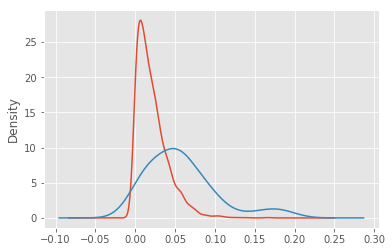

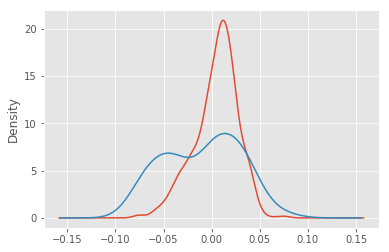

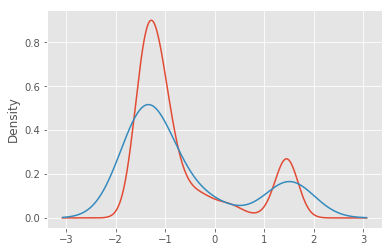

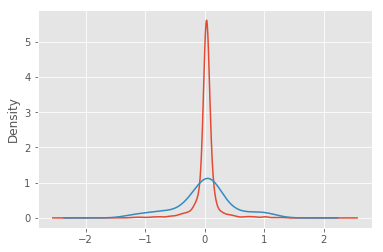

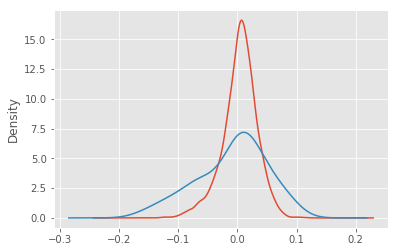

In [32]:
df_model.groupby("growth_sign").max_growth_p.plot(kind='kde')
plt.show()
df_model.groupby("growth_sign").dif_ema.plot(kind='kde')
plt.show()
df_model.groupby("growth_sign").theta_ema.plot(kind='kde')
plt.show()
df_model.groupby("growth_sign").strength_ema.plot(kind='kde')
plt.show()
df_model.groupby("growth_sign").ema_dif.plot(kind='kde')
plt.show()

In [18]:
X, y = df_model[['max_growth_p', 'dif_ema', 'theta_ema', 'strength_ema',
                'ema_dif']], df['growth_sign']
X.head()

,max_growth_p,dif_ema,theta_ema,strength_ema,ema_dif
5,0.009677,0.006023,0.115358,0.027626,0.011039
6,0.007832,0.006304,0.093905,0.027386,0.007796
7,0.003844,0.006559,0.054275,0.027303,0.007446
8,0.000851,0.006598,0.041576,0.026800,0.001283
9,0.006502,0.006604,-0.030088,0.027065,0.004954


In [19]:
y.head()

5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: growth_sign, dtype: float64

In [20]:
# from sklearn.decomposition import PCA
# X = StandardScaler().fit_transform(X)
# pca = PCA(n_components=2)
# principalComponents = pca.fit_transform(X)
# pca.components_
# principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1',
#                                                                   'principal component 2'])
# finalDf = pd.concat([principalDf, y], axis = 1)

In [21]:
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure(figsize = (8,8))
# ax = fig.add_subplot(1,1,1) 

# ax.set_title('3 component PCA', fontsize = 20)
# targets = [0,1]
# colors = ['r', 'g']
# for target, color in zip(targets,colors):
#     indicesToKeep = finalDf['growth_sign'] == target
#     ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
#                , finalDf.loc[indicesToKeep, 'principal component 2']
#                , c = color
#                , s = 50)
               
# ax.legend(targets)
# ax.grid()
# plt.show()

In [22]:
# df = finalDf
# X = df.drop(['growth_sign'],axis=1)
# y = df['growth_sign']

In [23]:
X = StandardScaler().fit_transform(X)

Unbalanced Dataset 0.0361923648984


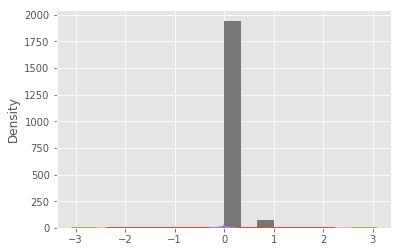

In [24]:
plt.hist(y, bins=3)
print('Unbalanced Dataset %s' % str(np.sum(y)/len(y)))
plt.show()

Unbalanced Dataset 0.321229050279


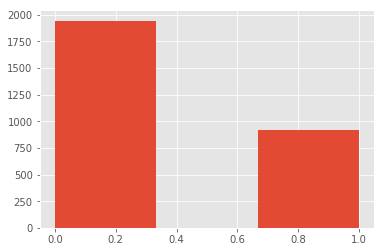

In [25]:
import math
oversampler = SMOTE(random_state=42, kind='svm',ratio={ 1:math.floor((len(y)*0.8))})
X_train_os, Y_train_os = oversampler.fit_sample(X,y)
plt.hist(Y_train_os, bins=3)
print('Unbalanced Dataset %s' % str(np.sum(Y_train_os)/len(Y_train_os)))
plt.show()

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y,
                                                    test_size=0.3, random_state=42)
import math
oversampler = SMOTE(random_state=42, kind='svm',ratio={ 1:math.floor((len(Y_train)*0.5))})
X_train_os, Y_train_os = oversampler.fit_sample(X_train,Y_train)

model = 'RF SMOTE GS'
param_grid = {'max_depth': np.arange(1, 20), 'min_samples_leaf':np.arange(1, 8)}

rf_os_cv = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc')
rf_os_cv.fit(X_train_os, Y_train_os)
print(rf_os_cv.best_params_)

{'max_depth': 8, 'min_samples_leaf': 2}


In [27]:
Y_predict = rf_os_cv.predict(X_test)

Unbalanced Dataset 0.0594059405941


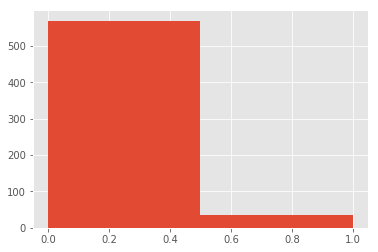

In [28]:
plt.hist(Y_predict, bins=2)
print('Unbalanced Dataset %s' % str(np.sum(Y_predict)/len(Y_predict)))
plt.show()

In [29]:
FP, TP, thresholds = roc_curve(Y_test,Y_predict)
roc_auc = auc(FP, TP)
print (roc_auc)

0.666544566545


In [30]:
cm = confusion_matrix(Y_test,Y_predict)
print(cm)
print('precision %s' % str(round((cm[1,1]/(cm[1,1]+cm[0,1])), 2)*100))

[[557  28]
 [ 13   8]]
precision 22.0


In [31]:
len(Y_test)

606